In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Carga de Función en un estado cuántico.

En este caso partiendo de un estado $|x\rangle_{n}\otimes|0\rangle_{1}$  aplicamos la siguiente transformación:

$$|x\rangle_{n}\hat{R}_{y}(2\theta_{x})|0\rangle_{1}$$
$$|x\rangle_{n}\otimes(\cos{\theta_{x}}|0\rangle_{1} + \sin{\theta_{x}}|1\rangle_{1})$$

Donde $$\theta_{x}=\arccos{\sqrt{f(x)}}$$

Siendo $f(x)$ la función que queremos cargar en el estado cuántico. Esta función tiene que estar correctamente discretizada.

La idea es generar en n qbits una superposición de estados y aplicar las transformación anterior:

Es decir partimos de 

$$|\Psi\rangle_{n}\otimes |0\rangle_{1} = \frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1}|x\rangle \otimes |0\rangle_{1}$$

y aplicamos la anterior transformación a todos y cada uno de los estados base anterior

$$\frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1}|x\rangle\hat{R}_{y}(2\theta_{x})|0\rangle_{1}$$

Es decir tenemos que sumar todas las posibles rotaciones controladas

## 1.Implementación

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os


In [3]:
Path = '/home/gferro/Code/PhaseAmplification/'
if os.path.exists(Path):
    sys.path.append(Path)
else: 
    raise FileNotFoundError('File does not exist')
from dataloading_module import get_histogram  

### 1.1. Inicialización

Debemos discretizar el dominio de la función y obtener los valores de la función sobre dicha discretización. Como nos va a interesar que el dominio de la probabilidad y de la función sea el mismo utilizamos la función **get_histogram** para obtener una discretización del dominio que nos valga para la probabilidad y para la función que queremos cargar!!

In [4]:
#Función de probabilidad de prueba
def p(x):
    return x*x

def f(x):
    return np.sin(x)
    

In [5]:
nqbits = 4
nbins = 2**nqbits
a = 0
b = 1

In [6]:
#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
#Queremos esto porque lo que me interesa es discretizar la función de forma
#acoplada a las probabilidades. Así pues para discretizar la función utilizamos
#el mismo dominio que el de la probabilidad.
DiscretizedFunction = p(centers)

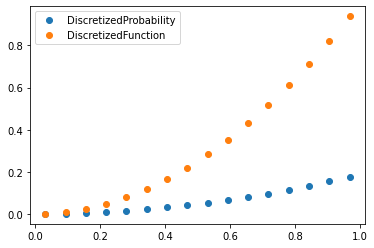

In [7]:
plt.plot(centers, probs, 'o')
plt.plot(centers, DiscretizedFunction, 'o')
plt.legend(['DiscretizedProbability', 'DiscretizedFunction'])

Se puede aprovechar mucho del trabajo realizado para la carga de la probabilidades. Ahora todo es un poco más sencillo (creo) ya que lo que tenemos que hacer es una suma de rotaciones controladas.

In [8]:
#calculamos los ángulos que tenemos que rotar
Thetas = np.arcsin(np.sqrt(DiscretizedFunction))

In [9]:
from qat.core.console import display
from qat.lang.AQASM import Program, QRoutine, H, AbstractGate

In [10]:
from dataloading_module import CRBS_gate

In [18]:
nqbits = 4
nbins = 2**nqbits
a = 0
b = 1

#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
#Queremos esto porque lo que me interesa es discretizar la función de forma
#acoplada a las probabilidades. Así pues para discretizar la función utilizamos
#el mismo dominio que el de la probabilidad.
DiscretizedFunction = f(centers)

#calculamos los ángulos que tenemos que rotar
Thetas = 2.0*np.arcsin(np.sqrt(DiscretizedFunction))


qprog = Program()
qcontrol = qprog.qalloc(nqbits+1)
#qtarget = qprog.qalloc(1)
#Generamos la superposición de estados para un estado de nqbits
for i in range(nqbits):
    qprog.apply(H, qcontrol[i])

#iteramos sobre todos los posibles estados de nqbits    
for i in range(nbins):
    #estado |i>
    controlledR_gate = CRBS_gate(nqbits, i, Thetas[i])    
    qprog.apply(controlledR_gate, qcontrol)

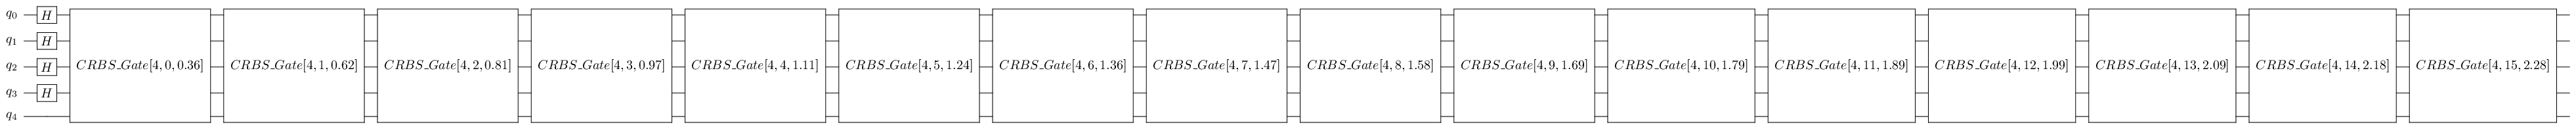

In [19]:
#Create the circuit from the program
circuit = qprog.to_circ()

#Display the circuit
%qatdisplay circuit
#%qatdisplay circuit --depth 1

In [20]:
#Create a Job from the circuit
job = circuit.to_job(qubits = [nqbits])
#job = circuit.to_job()
#Import and create the linear algebra simulator
from qat.qpus import LinAlg
linalgqpu = LinAlg()

#Submit the job to the simulator LinAlg and get the results
result = linalgqpu.submit(job)

In [23]:
QP = []
States = []
#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))
    QP.append(sample.probability)
    States.append(str(sample.state))
    
print('Quantum Measurement: {}'.format(QP[1]*2**(nqbits)))    
print('Integral: {}'.format(sum(DiscretizedFunction)))

State |0> probability 0.5402274767545427
State |1> probability 0.4597725232454565
Quantum Measurement: 7.356360371927304
Integral: 7.35636037192731


In [ ]:
import pandas as pd

In [ ]:
np.isclose(QP[1]*2**(nqbits), sum(DiscretizedFunction))

In [ ]:
sum(DiscretizedFunction)

## 2.Creamos Puerta de Carga de la Función

In [25]:
def CreateLoadFunctionGate(FunctionArray):
    
    #Number of qbits to codify Input Function
    nqbits_ = np.log2(len(FunctionArray))
    #FunctionArray array must have a dimension of 2^n.
    Condition = (nqbits_%2 ==0) or (nqbits_%2 ==1)
    if Condition == False:
        raise ValueError(
            'Length of the ProbabilityArray must be of dimension 2^n with n a int. In this case is: {}.'.format(nqbits)
        )
    nqbits_ = int(nqbits_)
    #Calculation of the rotation angles
    Thetas = 2.0*np.arcsin(np.sqrt(FunctionArray))
    
    def LoadFunction_generator(NumbeOfQbits):
        qrout = QRoutine()
        #The function will be load in the additional qbit
        qbits = qrout.new_wires(NumbeOfQbits+1)
        NumberOfStates = 2**NumbeOfQbits
        #Loop over the States
        for i in range(NumberOfStates):
            #State |i>
            
            #Generation of a Controlled rotation of theta by state |i>
            controlledR_gate = CRBS_gate(NumbeOfQbits, i, Thetas[i])    
            qrout.apply(controlledR_gate, qbits)
        return qrout
    
    LoadF_Gate = AbstractGate("R_Gate", [int])
    LoadF_Gate.set_circuit_generator(LoadFunction_generator)
    gate = LoadF_Gate(nqbits_)
    return gate        
        
    

In [26]:
nqbits = 6
nbins = 2**nqbits
a = 0
b = 1

#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
#Queremos esto porque lo que me interesa es discretizar la función de forma
#acoplada a las probabilidades. Así pues para discretizar la función utilizamos
#el mismo dominio que el de la probabilidad.
DiscretizedFunction = f(centers)

qprog = Program()
qcontrol = qprog.qalloc(nqbits+1)
#qtarget = qprog.qalloc(1)
#Generamos la superposición de estados para un estado de nqbits
for i in range(nqbits):
    qprog.apply(H, qcontrol[i])

R_gate = CreateLoadFunctionGate(DiscretizedFunction)    
qprog.apply(R_gate, qcontrol)

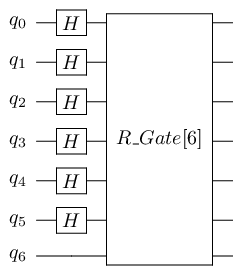

In [27]:
#Create the circuit from the program
circuit = qprog.to_circ()

#Display the circuit
%qatdisplay circuit
#%qatdisplay circuit --depth 2

In [28]:
#Create a Job from the circuit
job = circuit.to_job(qubits = [nqbits])
#job = circuit.to_job()
#Import and create the linear algebra simulator
from qat.qpus import LinAlg
linalgqpu = LinAlg()

#Submit the job to the simulator LinAlg and get the results
result = linalgqpu.submit(job)


QP = []
States = []
#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))
    QP.append(sample.probability)
    States.append(str(sample.state))
    
print('Quantum Measurement: {}'.format(QP[1]*2**(nqbits)))    
print('Integral: {}'.format(sum(DiscretizedFunction)))

print('Todo OK?: {}'.format(np.isclose(QP[1]*2**(nqbits), sum(DiscretizedFunction))))

State |0> probability 0.5402976295480755
State |1> probability 0.4597023704519237
Quantum Measurement: 29.420951708923116
Integral: 29.420951708923145
Todo OK?: True


## 3.Probamos la función en fichero python

La funcion que crea la puerta de carga la incorporo al fichero **dataloading_module.py** con el fin de tener todas las utilidades de carga de datos bien unificadas.

In [29]:
Path = '/home/gferro/Code/PhaseAmplification/'
if os.path.exists(Path):
    sys.path.append(Path)
else: 
    raise FileNotFoundError('File does not exist')
from dataloading_module import get_histogram , CreateLoadFunctionGate

In [30]:
from qat.core.console import display
from qat.lang.AQASM import Program, H

In [31]:
nqbits = 6
nbins = 2**nqbits
a = 0
b = 1

#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
#Queremos esto porque lo que me interesa es discretizar la función de forma
#acoplada a las probabilidades. Así pues para discretizar la función utilizamos
#el mismo dominio que el de la probabilidad.
DiscretizedFunction = f(centers)
qprog = Program()
qcontrol = qprog.qalloc(nqbits+1)
#qtarget = qprog.qalloc(1)
#Generamos la superposición de estados para un estado de nqbits
for i in range(nqbits):
    qprog.apply(H, qcontrol[i])

R_gate = CreateLoadFunctionGate(DiscretizedFunction)    
qprog.apply(R_gate, qcontrol)

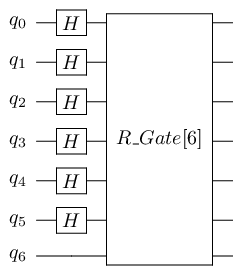

In [32]:
#Create the circuit from the program
circuit = qprog.to_circ()

#Display the circuit
%qatdisplay circuit
#%qatdisplay circuit --depth 2

In [33]:
#Create a Job from the circuit
job = circuit.to_job(qubits = [nqbits])
#job = circuit.to_job()
#Import and create the linear algebra simulator
from qat.qpus import LinAlg
linalgqpu = LinAlg()

#Submit the job to the simulator LinAlg and get the results
result = linalgqpu.submit(job)


QP = []
States = []
#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))
    QP.append(sample.probability)
    States.append(str(sample.state))
    
print('Quantum Measurement: {}'.format(QP[1]*2**(nqbits)))    
print('Integral: {}'.format(sum(DiscretizedFunction)))

print('Todo OK?: {}'.format(np.isclose(QP[1]*2**(nqbits), sum(DiscretizedFunction))))

State |0> probability 0.857009008414741
State |1> probability 0.14299099158525805
Quantum Measurement: 9.151423461456515
Integral: 29.420951708923145
Todo OK?: False


## 4. Programa Juan

Quiero comprobar que mi implementación es consistente con la implementación realizada en el programa de Juan

In [ ]:
sys.path.append('/home/gferro/Code/ProgramasDefinitivos')

In [ ]:
from expectation_module import load_function

In [ ]:
nqbits = 6
nbins = 2**nqbits
a = 0
b = 1

#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
R_gate, y = load_function(centers, p, nqbits)

In [ ]:
qprog = Program()
qbits = qprog.qalloc(nqbits+1)
for i in range(nqbits):
    qprog.apply(H, qbits[i])
qprog.apply(R_gate, qbits)    

In [ ]:
#Create the circuit from the program
circuit = qprog.to_circ()

#Display the circuit
#%qatdisplay circuit
%qatdisplay circuit --depth 0

In [ ]:
#Create a Job from the circuit
job = circuit.to_job(qubits = [nqbits])

#Import and create the linear algebra simulator
from qat.qpus import LinAlg
linalgqpu = LinAlg()

#Submit the job to the simulator LinAlg and get the results
result = linalgqpu.submit(job)

In [ ]:
QP = []
States = []
#Print the results
for sample in result:
    print("State %s probability %s" % (sample.state, sample.probability))
    QP.append(sample.probability)
    States.append(str(sample.state))
print('Quantum Measurement: {}'.format(QP[1]*2**(nqbits)))    
print('Integral: {}'.format(sum(y)))    

In [ ]:
np.isclose(QP[1]*2**(nqbits), sum(DiscretizedFunction))

In [ ]:
States = pd.Series(States)
QP = pd.Series(QP)

In [ ]:
np.isclose(sum(QP[States.str.extract(r'(\d)\>')[0] == '1'])*(2**(nqbits)),sum(DiscretizedFunction))

In [ ]:
sum(QP[States.str.extract(r'(\d)\>')[0] == '0'])*(2**(nqbits))

In [ ]:
sum(DiscretizedFunction)